In [2]:
import os
import sys
import random
import shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, model_from_json
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Paths and Constants

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
TRAIN_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\train_seg'
MASK_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\masks_extended'
TEST_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-test-dataset'

# CNN Model and Objective function

In [4]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

# Load and resize train images

In [5]:
filenames = [f for f in os.listdir(MASK_PATH)]

for idx, name in enumerate(filenames):
    try:
        shutil.copy(os.path.join(r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-training-dataset_origin', name), 
             os.path.join(TRAIN_PATH, name))
    except:
        print('fail to copy ' + name)

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(filenames), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(filenames), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in enumerate(filenames):
    path = os.path.join(TRAIN_PATH,id_)
    try:
        img = np.expand_dims(imread(path)[:,:], axis=2)    
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
        mask_path = os.path.join(MASK_PATH,id_)
        mask = np.expand_dims(imread(mask_path)[:,:,0], axis=-1)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        mask = (mask > 200).astype(np.uint8)
        Y_train[n,:,:,:] = mask
    except:
        print('error in ' + path)

# Training Phase

In [13]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=20, 
                    callbacks=[earlystopper])

model_json = model.to_json()
with open("model_segmentation.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_segmentation_weights.h5")
print("Saved model to disk")

Train on 4177 samples, validate on 465 samples
Epoch 1/20
4177/4177 [==============================] - 523s 125ms/step - loss: 0.0437 - mean_iou: 0.9370 - val_loss: 0.0454 - val_mean_iou: 0.9373
Epoch 2/20
4177/4177 [==============================] - 565s 135ms/step - loss: 0.0439 - mean_iou: 0.9377 - val_loss: 0.0430 - val_mean_iou: 0.9380
Epoch 3/20
4177/4177 [==============================] - 582s 139ms/step - loss: 0.0409 - mean_iou: 0.9384 - val_loss: 0.0474 - val_mean_iou: 0.9387
Epoch 4/20
4177/4177 [==============================] - 586s 140ms/step - loss: 0.0395 - mean_iou: 0.9391 - val_loss: 0.0486 - val_mean_iou: 0.9394
Epoch 5/20
4177/4177 [==============================] - 590s 141ms/step - loss: 0.0400 - mean_iou: 0.9397 - val_loss: 0.0500 - val_mean_iou: 0.9401
Epoch 6/20
4177/4177 [==============================] - 592s 142ms/step - loss: 0.0388 - mean_iou: 0.9404 - val_loss: 0.0461 - val_mean_iou: 0.9407
Epoch 7/20
4177/4177 [==============================] - 590s 141m

# Inference Phase

In [8]:
#load test data
test_filenames = os.listdir(TEST_PATH)
X_test = np.zeros((len(test_filenames), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, file in enumerate(test_filenames):
    filepath = os.path.join(TEST_PATH,file) 
    current_img = np.expand_dims(imread(filepath)[:,:], axis=2)    
    current_img = resize(current_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
    X_test[n] = current_img

In [9]:
# load json and create model
json_file = open('model_segmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_segmentation_weights.h5")
print("Loaded model from disk")

y_pred = loaded_model.predict(X_test)

Loaded model from disk


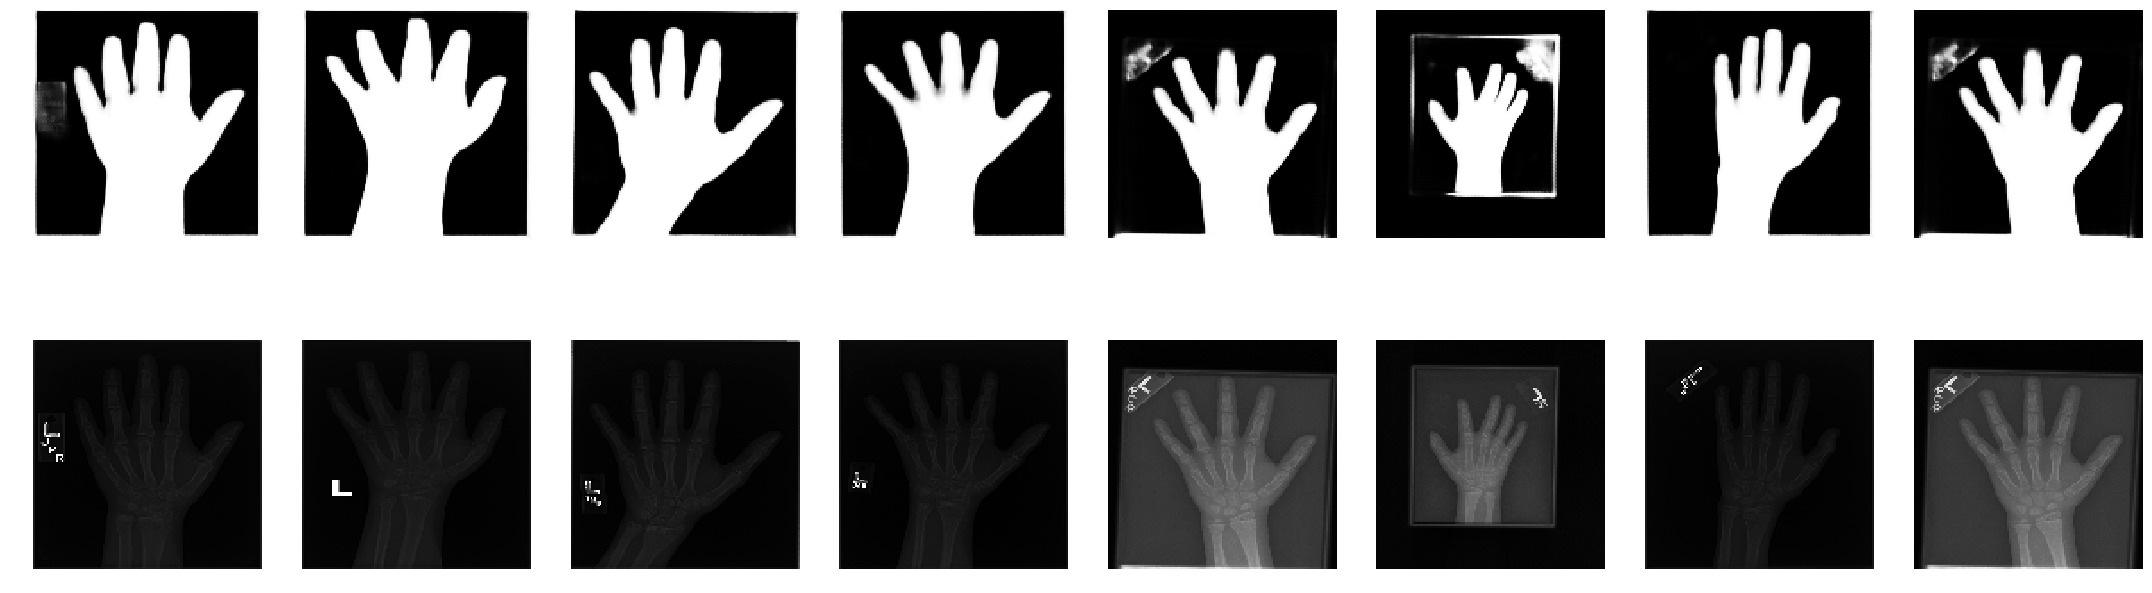

In [18]:
def showRandomDataFromArray(seg_array, origin_array, numOfFigs=10):
    fig, axes = plt.subplots(2, numOfFigs, figsize=(30, 10))
    for i in range(0, numOfFigs):
        index = random.randint(0, seg_array.shape[0])
        axes[0][i].imshow(seg_array[index,: , :, 0], cmap='gray')
        axes[1][i].imshow(origin_array[index, :, :, 0], cmap='gray')
        axes[0][i].axis('off')        
        axes[1][i].axis('off')        

    plt.tight_layout()
    plt.show()
    
showRandomDataFromArray(y_pred, X_test, numOfFigs=8)

# save segmentations to file for further usage

In [11]:
pred_path = os.path.join(TEST_PATH, 'pred')
os.mkdir(pred_path)
for n, img in enumerate(y_pred):
    segmentation_name = 'seg_reg_' + str(n) + '.png'
    imsave(os.path.join(pred_path, segmentation_name), img[:,:,0])

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


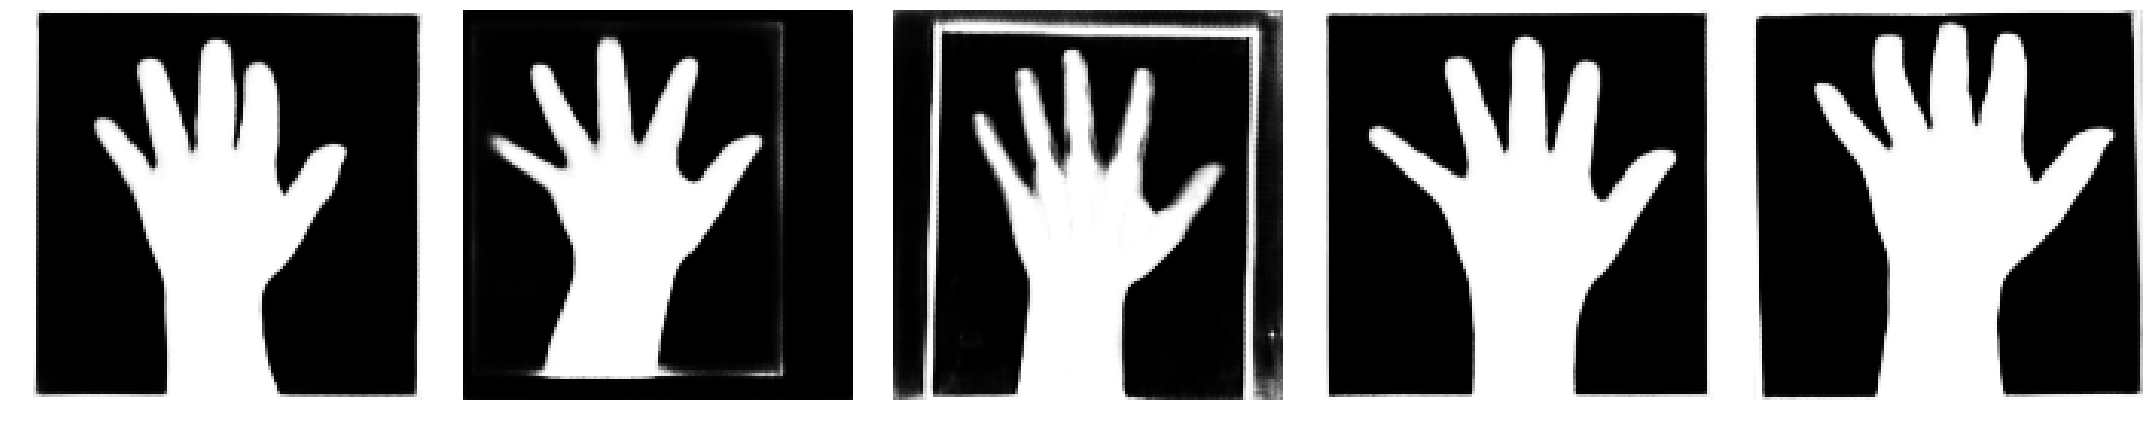

In [22]:
listOfImgs = img_utils.showRandomDataFromFolder(pred_path, numOfFigs=5)